In [1]:
import sys
sys.path.append("..")

import numpy as np
import torch
from matplotlib import pyplot as plt
from inflation import  BBI
import json
from numpy import arange

from utils_synthetic import *

import sys
#!{sys.executable} -m pip install hyperopt
!mkdir -p results
from hyperopt import hp, tpe, Trials, fmin
from hyperopt.pyll.base import scope 

In [2]:
device = 'cpu'
n = 2

def ackley(xs):
    return -20*torch.exp(-.02*torch.sqrt((torch.norm(xs)**2)/n))-torch.exp(torch.sum(torch.cos(2*np.pi*xs))/n) +20+np.e

global_min = torch.tensor([0.,0., 0., 0., 0.])[:n]
print(ackley(global_min))

xs = torch.tensor([-4.0,  3.0])

tensor(9.5367e-07)


In [3]:
potential = ackley

def hyperopt_tuning(ranges, ranges_integer, optimizer, tune_iterations=1000, n_trials=100, **fixed_pars):
  
    def optimizer_func(pars):
        xs = optimizer(x0, potential, iterations=tune_iterations, **pars, **fixed_pars)
        return potential(xs).item()

    fspace = {}
    for par, range in ranges.items(): fspace[par] = hp.uniform(par, *range)
    for par, range in ranges_integer.items(): fspace[par] = scope.int(hp.uniform(par, *range))

    trials = Trials()
    best = fmin(fn=optimizer_func, space=fspace, algo=tpe.suggest, trials=trials, max_evals=n_trials)
    return best

In [4]:
#common parameters
tune_iterations = 200 
n_trials = 500
test_iterations = 100*tune_iterations

x0 = xs.tolist()

In [5]:
#sgd

best_par_sgd = hyperopt_tuning({'lr': [.00001,.5], 'momentum': [0,1.0]},{}, sgd_optimizer, tune_iterations=tune_iterations, n_trials=n_trials)
print("sgd:", best_par_sgd)

with open('sgd-param-ackley.txt', 'w') as filehandle:
    json.dump( best_par_sgd, filehandle)



100%|██████| 500/500 [00:28<00:00, 17.43trial/s, best loss: 0.02798175811767578]
sgd: {'lr': 0.1992562204241242, 'momentum': 0.5633869657709932}


In [6]:
#sgd - gamma

best_par_sgd_gamma = hyperopt_tuning({'lr': [.00001,.5], 'gamma': [0,10000000000]},{}, sgd_optimizer_gamma, tune_iterations=tune_iterations, n_trials=n_trials)

print("sgd gamma:", best_par_sgd_gamma)

with open('sgd-gamma-param-ackley.txt', 'w') as filehandle:
    json.dump(best_par_sgd, filehandle)

100%|█████| 500/500 [00:27<00:00, 17.86trial/s, best loss: 0.006609916687011719]
sgd gamma: {'gamma': 940888900.3214041, 'lr': 0.25312618982640617}


In [7]:
##BBI
deltaEn = 2.0

# these are fixed
threshold0 = 20
n_fixed_bounces = 4
threshold = 100
v0 = 1e-4
consEn = True

#we scan only on lr

best_par_BBI = hyperopt_tuning({'lr': [1e-6,1e-2]},{}, BBI_optimizer, tune_iterations=tune_iterations,  n_trials=n_trials,
    threshold0 = threshold0,threshold = threshold, deltaEn = deltaEn, v0 = v0,  n_fixed_bounces = n_fixed_bounces , consEn = consEn)


best_par_BBI['deltaEn'] = deltaEn
best_par_BBI['v0'] = v0
best_par_BBI['threshold0'] = threshold0
best_par_BBI['threshold'] = threshold
best_par_BBI['n_fixed_bounces'] = n_fixed_bounces
best_par_BBI['consEn'] = True

print("BBI:", best_par_BBI)

with open('bbi-param-ackley.txt', 'w') as filehandle:
    json.dump( best_par_BBI, filehandle)



100%|███████| 500/500 [00:33<00:00, 14.81trial/s, best loss: 1.1645097732543945]
BBI: {'lr': 0.009649484068918336, 'deltaEn': 2.0, 'v0': 0.0001, 'threshold0': 20, 'threshold': 100, 'n_fixed_bounces': 4, 'consEn': True}


Final loss:  0.6418962478637695
Final loss:  0.3714590072631836
Final loss:  9.632110595703125e-05
Final loss:  0.08959484100341797
Final loss:  0.1791849136352539
Best loss:  9.632110595703125e-05


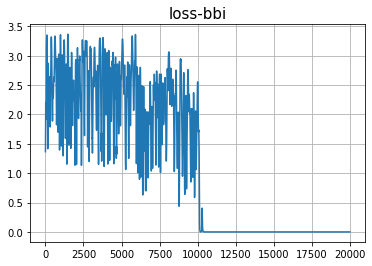

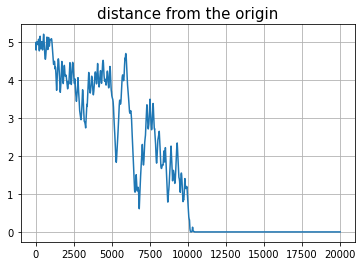

In [8]:
#nchecks > 1 is useful for non-deterministic algorithms
# The global minimum is not found 100% of the time within the specified iterations, but was found in 90 percent of runs, see end of section 4.1.
min_BBI = 1e20
nchecks = 5

for i in range(nchecks):
    x0 =xs.tolist()
    xslist = BBI_optimizer_fullhistory(x0, potential, iterations=test_iterations, **best_par_BBI)
    min_temp = 1e20

    for elem in xslist:
        elem_tens_val  = ackley(torch.tensor(elem))
        if elem_tens_val < min_temp:
            min_temp = elem_tens_val.item()
    fin_val = min_temp
    print("Final loss: ", fin_val )
    if fin_val < min_BBI:
        min_BBI = fin_val
        xs_list_BBI = xslist

print("Best loss: ", min_BBI )
plotting(ackley, xs_list_BBI, "loss-bbi")
plotting(distance, xs_list_BBI, "distance from the origin")

Final loss:  0.02798175811767578
Best loss:  0.02798175811767578


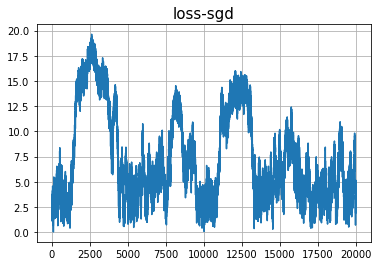

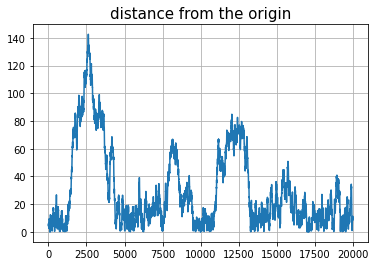

In [9]:
#sgd
#nchecks > 1 is useful for non-deterministic algorithms
min_sgd = 1e20
nchecks = 1

for i in range(nchecks):
    x0 =xs.tolist()
    xslist = sgd_optimizer_fullhistory(x0, potential, iterations=test_iterations, **best_par_sgd )
    min_temp = 1e20

    for elem in xslist:
        elem_tens_val  = ackley(torch.tensor(elem))
        if elem_tens_val < min_temp:
            min_temp = elem_tens_val.item()
        
    fin_val = min_temp
    print("Final loss: ", fin_val )
    if fin_val < min_sgd:
        min_sgd = fin_val
        xslist_sgd = xslist

print("Best loss: ", min_sgd )
plotting(ackley, xslist_sgd, "loss-sgd")
plotting(distance, xslist_sgd, "distance from the origin")

Final loss:  0.006609916687011719
Best loss:  0.006609916687011719


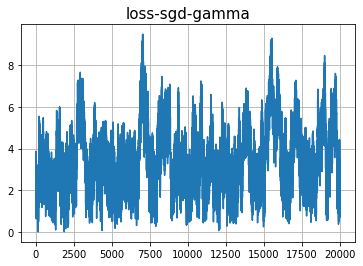

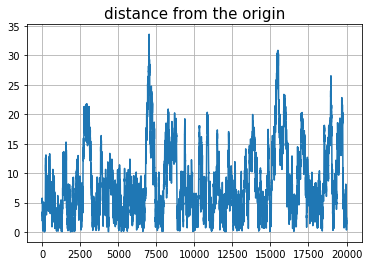

In [10]:
#sgd-gamma
#nchecks > 1 is useful for non-deterministic algorithms
min_sgd_gamma = 1e20
nchecks = 1

for i in range(nchecks):
    x0 =xs.tolist()
    xslist = sgd_optimizer_gamma_fullhistory(x0, potential, iterations=test_iterations, **best_par_sgd_gamma )
    
    min_temp = 1e20

    for elem in xslist:
        elem_tens_val  = ackley(torch.tensor(elem))
        if elem_tens_val < min_temp:
            min_temp = elem_tens_val.item()
        
    fin_val = min_temp

    print("Final loss: ", fin_val )
    if fin_val < min_sgd_gamma:
        min_sgd_gamma = fin_val
        xslist_sgd_gamma = xslist

print("Best loss: ", min_sgd_gamma )
plotting(ackley, xslist_sgd_gamma, "loss-sgd-gamma")
plotting(distance, xslist_sgd_gamma, "distance from the origin")

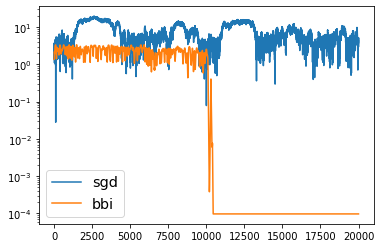

In [11]:
losses_sgd = []
for elem in xslist_sgd: losses_sgd.append(ackley(torch.tensor(elem)))

losses_bbi = []
for elem in xs_list_BBI: losses_bbi.append(ackley(torch.tensor(elem)))

plt.plot(losses_sgd, label="sgd")
plt.plot(losses_bbi, label="bbi")
plt.yscale('log')
plt.legend(loc='lower left', shadow=False, fontsize='x-large')

In [12]:
# We can also compare with SGD with a smaller lrs

#sgd smaller
best_par_sgd_smaller = hyperopt_tuning({'lr': [.00001,.05], 'momentum': [0,1.0]},{}, sgd_optimizer, tune_iterations=tune_iterations,  n_trials=n_trials)

print("sgd:", best_par_sgd_smaller)


with open('sgd-smaller-param-ackley.txt', 'w') as filehandle:
    json.dump( best_par_sgd_smaller, filehandle)

100%|███████| 500/500 [00:29<00:00, 16.93trial/s, best loss: 1.3647222518920898]
sgd: {'lr': 0.003128590170780255, 'momentum': 0.8819287118465282}


Final loss:  1.3647222518920898
Best loss:  1.3647222518920898


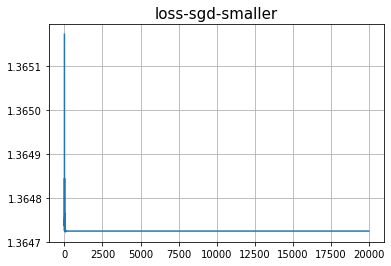

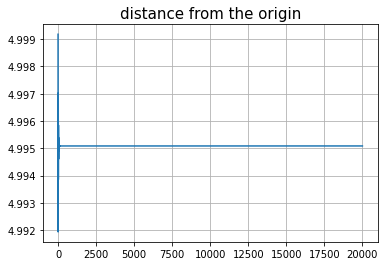

In [13]:
# Runs with the best parameters
#sgd
#nchecks > 1 is useful for non-deterministic algorithms
min_sgd_smaller = 1e20
nchecks = 1

for i in range(nchecks):
    x0 =xs.tolist()
    xslist = sgd_optimizer_fullhistory(x0, potential, iterations=test_iterations, **best_par_sgd_smaller )
    min_temp = 1e20

    for elem in xslist:
        elem_tens_val  = ackley(torch.tensor(elem))
        if elem_tens_val < min_temp:
            min_temp = elem_tens_val.item()
        
    fin_val = min_temp
    print("Final loss: ", fin_val )
    if fin_val < min_sgd_smaller:
        min_sgd_smaller = fin_val
        xslist_sgd_smaller = xslist

print("Best loss: ", min_sgd_smaller )
plotting(ackley, xslist_sgd_smaller, "loss-sgd-smaller")
plotting(distance, xslist_sgd_smaller, "distance from the origin")

losses_sgd_smaller= []
for elem in xslist_sgd_smaller: losses_sgd_smaller.append(ackley(torch.tensor(elem)))

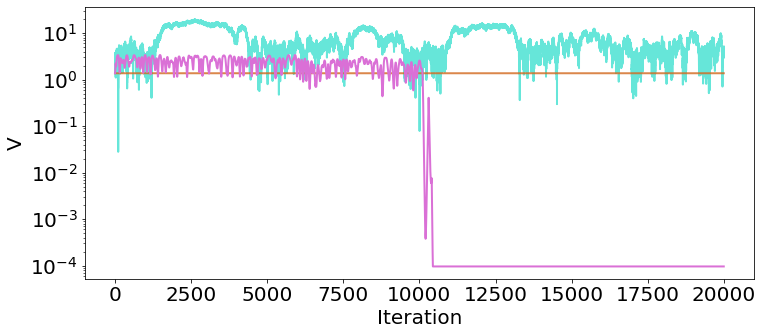

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(losses_sgd, label="GDM", alpha=.8, linewidth=2, color='turquoise')
plt.plot(losses_sgd_smaller, label="GDM - small stepsize", alpha = .8, linewidth=2, color='chocolate')
plt.plot(losses_bbi, label="BBI", linewidth=2, color='orchid')

plt.xlabel('Iteration', fontsize = 20)
plt.ylabel('V', fontsize = 20)
plt.yscale('log')
#plt.legend(loc='best', shadow=False, fontsize='x-large')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.savefig('hyperopt-ackley.pdf',bbox_inches='tight')


In [15]:
epsilon = 5e-4 # this defines success
n_points = 100
n_checks_per_point = 5

test_iterations_random_point = 150*tune_iterations

successes = 0

rangemin = -4
rangemax =4
unif=torch.distributions.uniform.Uniform(torch.tensor(rangemin,dtype=torch.float32, device = device),torch.tensor(rangemax, dtype=torch.float32, device = device)) 


for i in range(n_points):
    xs_try = unif.sample((n,))
    x0 =xs_try.tolist()
    for j in range(n_checks_per_point):
        res = potential(BBI_optimizer(x0, potential, iterations=test_iterations_random_point, **best_par_BBI))
        if res < epsilon:
            successes += 1
            break
successes_bbi = successes

In [16]:
# and do it also for sgd, but no need to run multiple evolution per each point (they are all the same)

epsilon = 5e-4 # this defines success
n_points = 100
n_checks_per_point = 1

test_iterations_random_point = 150*tune_iterations # number of iterations per run

successes = 0

rangemin = -4
rangemax =4
unif=torch.distributions.uniform.Uniform(torch.tensor(rangemin,dtype=torch.float32, device = device),torch.tensor(rangemax, dtype=torch.float32, device = device)) 


for i in range(n_points):
    xs_try = unif.sample((n,))
    x0 =xs_try.tolist()
    for j in range(n_checks_per_point):
        res = potential(sgd_optimizer(x0, potential, iterations=test_iterations_random_point, **best_par_sgd))
        if res < epsilon:
            successes += 1
            break
successes_sgd = successes

In [17]:
print(successes_sgd)
print(successes_bbi)

0
83
